# Introduction
* In this notebook, I will explor PyStan package.
* [Reference](https://pystan.readthedocs.io/en/latest/getting_started.html)

In [1]:
import pystan
import scipy
import arviz
import plotly.express as px
import plotly.graph_objs as go


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Example: eight schools

In [ ]:
data {
int<lower=0> J; // # schools
real y[J]; // estimated treatment
real<lower=0> sigma[J]; // std err of effect
}
parameters {
real theta[J]; // school effect
real mu; // mean for schools
real<lower=0> tau; // variance between schools
}
model {
theta ~ normal(mu, tau);
y ~ normal(theta, sigma);
}

In [2]:
# ref: https://pystan.readthedocs.io/en/latest/getting_started.html
# https://astrostatistics.psu.edu/su14/lectures/Daniel-Lee-Stan-2.pdf

schools_code = """
data {
    int<lower=0> J; // # schools
    real y[J]; // estimated treatment
    real<lower=0> sigma[J]; // std err of effect
}
parameters {
    real theta[J]; // school effect
    real mu; // mean for schools
    real<lower=0> tau; // variance between schools
}
model {
    theta ~ normal(mu, tau);
    y ~ normal(theta, sigma);
}
"""

schools_dat = {'J': 8,
               'y': [28,  8, -3,  7, -1,  1, 18, 12],
               'sigma': [15, 10, 16, 11,  9, 11, 10, 18]}

sm = pystan.StanModel(model_code=schools_code)
fit = sm.sampling(data=schools_dat, iter=3000, warmup=300, chains=3, 
                  thin=1) # control={'adapt_delta': 0.9, 'max_treedepth': 30}

#fit = sm.sampling(data=schools_dat, iter=1000, warmup=300, chains=4, thin=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb61d0eae3d6ef378c04e5c9a4c3d37a NOW.


In [3]:
# Extract samples
la = fit.extract(permuted=True)  # return a dictionary of arrays

## return an array of three dimensions: iterations, chains, parameters
a = fit.extract(permuted=False)

In [4]:
print(fit)

Inference for Stan model: anon_model_bb61d0eae3d6ef378c04e5c9a4c3d37a.
3 chains, each with iter=3000; warmup=300; thin=1; 
post-warmup draws per chain=2700, total post-warmup draws=8100.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]  11.54     0.2   8.45  -2.49   5.74  10.51  15.99  31.66   1763    1.0
theta[2]    7.7    0.12   6.49  -5.24   3.54   7.65  11.86  20.54   3147    1.0
theta[3]   5.75    0.14   7.88  -11.6    1.4   6.09  10.67  20.63   3353    1.0
theta[4]   7.48    0.11   6.82  -6.46   3.29   7.44  11.62  21.08   3744    1.0
theta[5]   4.56    0.12   6.51  -9.37   0.68   4.89   8.96  16.52   3099    1.0
theta[6]    5.6    0.12   6.94  -9.35   1.49   5.82  10.12  18.52   3082    1.0
theta[7]  10.77    0.17   6.94  -1.51   5.91   10.3  14.95   26.2   1654    1.0
theta[8]   8.29    0.14   8.33  -8.35   3.48   8.09  12.99  25.49   3729    1.0
mu         7.59    0.12    5.2  -2.34   4.28   7.55  10.87  17.74   1981    1.0
tau        7

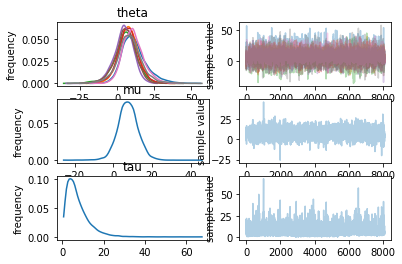

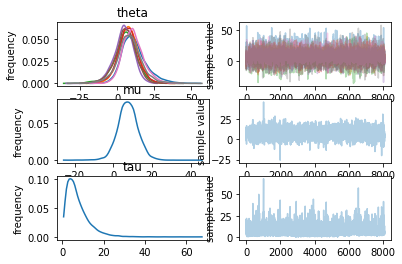

In [5]:
fit.plot()

# Create two samples and use PyStan to see fitting results

In [6]:
size = 10000
shape_list = [0.8, 1]  # k  (alpha)
scale_general = 10  # theta   (beta = 1 / theta)


x1 = np.random.gamma(shape=shape_list[0], scale=scale_general, size=size)
x2 = np.random.gamma(shape=shape_list[1], scale=scale_general, size=size)

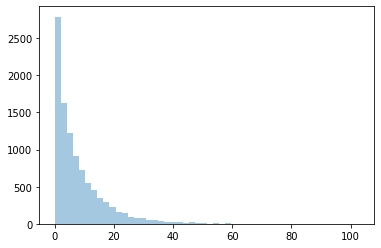

In [7]:
sns.distplot(x1, kde=False)

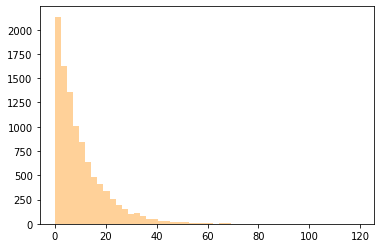

In [8]:
sns.distplot(x2, kde=False, color='darkorange')

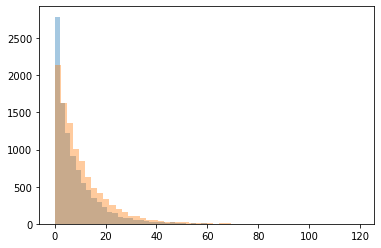

In [9]:
sns.distplot(x1, kde=False)
sns.distplot(x2, kde=False)

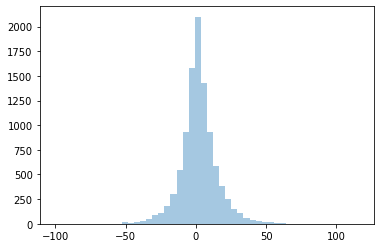

In [10]:
sns.distplot(x2 - x1, kde=False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_04cbf2f663896ca538174a7c8d43834b NOW.


Inference for Stan model: anon_model_04cbf2f663896ca538174a7c8d43834b.
3 chains, each with iter=3000; warmup=300; thin=1; 
post-warmup draws per chain=2700, total post-warmup draws=8100.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
shape1    0.8  1.4e-4 8.3e-3   0.79    0.8    0.8   0.81   0.82   3515    1.0
shape2   1.01  1.8e-4   0.01   0.99    1.0   1.01   1.02   1.03   3465    1.0
scale     0.1  2.2e-5 1.2e-3    0.1    0.1    0.1    0.1    0.1   3005    1.0
d        0.21  1.4e-4   0.01   0.19    0.2   0.21   0.21   0.23   5609    1.0
lp__   -6.4e4    0.02   1.24 -6.4e4 -6.4e4 -6.4e4 -6.4e4 -6.4e4   3523    1.0

Samples were drawn using NUTS at Wed Mar  4 15:26:52 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


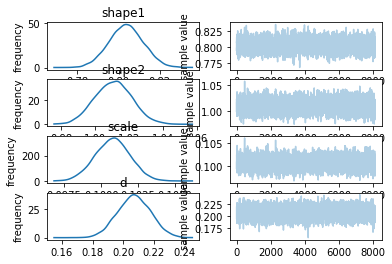

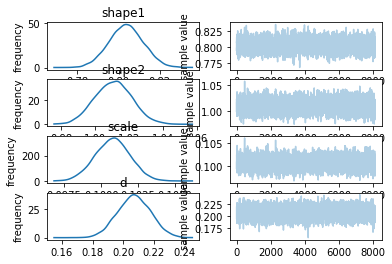

In [11]:
before_after_code = """
data {
    int<lower=0> J; // length of data
    vector[J] x1; // before
    vector[J] x2; // after
}
parameters {
    real<lower=0> shape1;
    real<lower=0> shape2;
    real<lower=0> scale;
}
model {
    x1 ~ gamma(shape1, scale);
    x2 ~ gamma(shape2, scale);
}

generated quantities {
    real d;
    
    d = shape2 - shape1;
}
"""

before_after_data = {'J': size,
               'x1': x1,
               'x2': x2}

sm = pystan.StanModel(model_code=before_after_code)
fit = sm.sampling(data=before_after_data, iter=3000, warmup=300, chains=3)

print(fit)
fit.plot()

In [12]:
a = fit.extract(permuted=True)

In [72]:
a

OrderedDict([('shape1',
              array([0.82063776, 0.80396779, 0.81154836, ..., 0.82363363, 0.80661672,
                     0.80137586])),
             ('shape2',
              array([1.01167893, 0.99264428, 0.98631749, ..., 0.99163856, 1.0083052 ,
                     0.98382181])),
             ('scale',
              array([0.10193114, 0.09973488, 0.09961236, ..., 0.10003887, 0.09939615,
                     0.09919239])),
             ('d',
              array([0.19104117, 0.18867648, 0.17476913, ..., 0.16800493, 0.20168848,
                     0.18244594])),
             ('lp__',
              array([-63743.41205766, -63741.66941359, -63742.11130898, ...,
                     -63744.00940861, -63743.80442165, -63742.21558393]))])

In [74]:
len(a['shape1'])

8100

In [56]:
a.shape

(2700, 3, 5)

In [58]:
fit.summary()

OrderedDict([('summary',
              array([[ 8.08097116e-01,  1.32291365e-04,  8.27349498e-03,
                       7.92134820e-01,  8.02418628e-01,  8.07906541e-01,
                       8.13730542e-01,  8.24607964e-01,  3.91124499e+03,
                       1.00004324e+00],
                     [ 9.94389958e-01,  1.68498249e-04,  1.04297694e-02,
                       9.74137228e-01,  9.87346707e-01,  9.94412173e-01,
                       1.00132489e+00,  1.01534676e+00,  3.83140998e+03,
                       1.00010130e+00],
                     [ 9.98123079e-02,  1.91671265e-05,  1.14605356e-03,
                       9.75859892e-02,  9.90382312e-02,  9.98123735e-02,
                       1.00584186e-01,  1.02058599e-01,  3.57516271e+03,
                       9.99872959e-01],
                     [ 1.86292842e-01,  1.35057793e-04,  1.04581078e-02,
                       1.65874308e-01,  1.79261742e-01,  1.86374889e-01,
                       1.93316475e-01,  2.06685499e-

In [13]:
shape1 = fit['shape1']
shape2 = fit['shape2']
scale = fit['scale']
d = fit['d']
lp = fit['lp__']

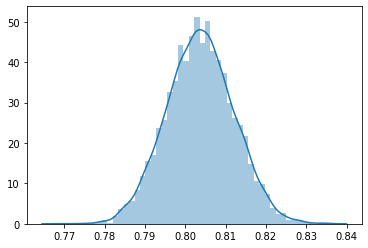

In [14]:
sns.distplot(shape1)

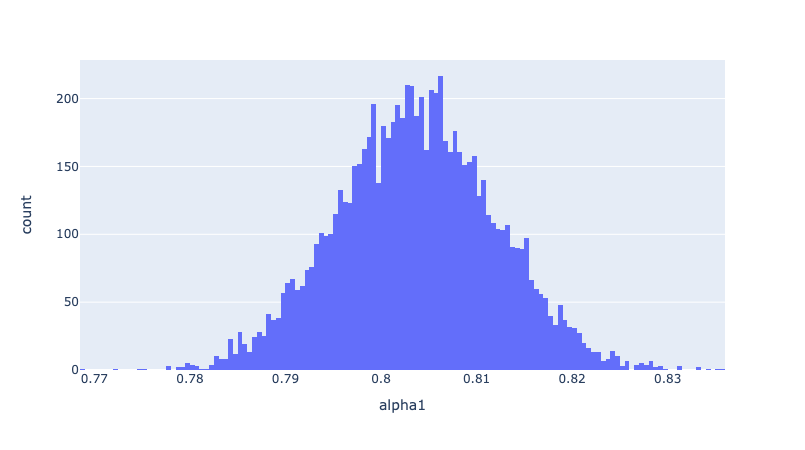

In [16]:
px.histogram(x=shape1, labels={"x":"alpha1"})

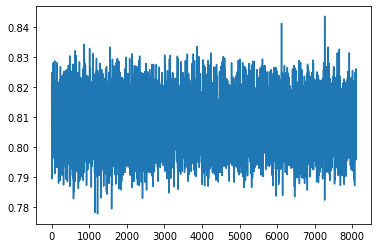

In [76]:
plt.plot(a['shape1'])

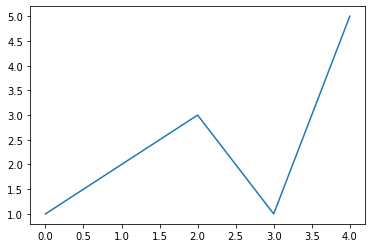

In [81]:
plt.plot([1,2,3,1,5])

In [137]:
before_after_code = """
data {
    int<lower=0> J; // length of data
    vector[J] x1; // before
    vector[J] x2; // after
}
parameters {
    real<lower=0> shape1;
    real<lower=0> shape2;
    real<lower=0> scale;
}
model {
    x1 ~ uniform(shape1 - 1, shape1 + 1);
    x2 ~ uniform(shape2 - 1, shape2 + 1);
}

generated quantities {
    real d;
    
    d = shape2 - shape1;
}
"""

before_after_dat = {'J': size,
               'x1': x1,
               'x2': x2}

sm = pystan.StanModel(model_code=before_after_code)
fit = sm.sampling(data=before_after_dat, iter=3000, warmup=300, chains=3)
                  # thin=1) # control={'adapt_delta': 0.9, 'max_treedepth': 30}

print(fit)
fit.plot()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3a0a6957952c8151fd5eef84d8c8b5c6 NOW.


RuntimeError: Initialization failed.